# Reassign DecisionTree leaves by $\Delta$IA

## Load Balrog-Bagpipes catalog

In [1]:
import pickle

In [2]:
file = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/balrog-bagpipes.pkl'
data = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of Balrog-Bagpipes catalog: {len(data)}')

Length of Balrog-Bagpipes catalog: 2417437


In [3]:
data = data.dropna(subset=['stell_best', 'ssfr_best'])
print(f'Length of Balrog-Bagpipes catalog (no nan): {len(data)}')

Length of Balrog-Bagpipes catalog (no nan): 2417396


In [4]:
for i in range(4):
    print(f"Length of Balrog-Bagpipes Bin{i}: {len(data[data['bin']==i])}")

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


## Load DecisionTrees and train/test samples, predictions

In [5]:
import joblib
import pandas as pd

In [6]:
decisiontree_dir = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/'
decisiontree_file_template = decisiontree_dir + 'decisiontree_bin{}.joblib'

classifiers = {}

for i in range(4):
    print(f'Loading DecisionTree Bin{i}')
    classifiers[i] = joblib.load(decisiontree_file_template.format(i))

Loading DecisionTree Bin0
Loading DecisionTree Bin1
Loading DecisionTree Bin2
Loading DecisionTree Bin3


/global/homes/e/elegnani/.conda/envs/cosmo_env/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
file = '/global/cfs/cdirs/des/elisa/IA_decisiontree/decisiontree_data/decisiontree_predictions.pkl'
predictions = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of predictions catalog: {len(predictions)}')

# Add predictions to data
data = pd.merge(data, predictions, on='bal_id', how='inner') # Oss: checked it does it correctly

Length of predictions catalog: 2417396


In [8]:
for i in range(4):
    X_test = data[(data['bin'] == i) & (data['label_pred'] != -1)]
    print(f'Bin{i}')
    print(f"- Number of blue galaxies: {len(X_test[X_test['label_pred']==0])}")
    print(f"- Number of red galaxies:  {len(X_test[X_test['label_pred']==1])}")
    print(f'Number of leaves: {classifiers[i].get_n_leaves()}')
    print()

Bin0
- Number of blue galaxies: 67964
- Number of red galaxies:  54745
Number of leaves: 2910

Bin1
- Number of blue galaxies: 66327
- Number of red galaxies:  55298
Number of leaves: 3145

Bin2
- Number of blue galaxies: 64137
- Number of red galaxies:  56955
Number of leaves: 3072

Bin3
- Number of blue galaxies: 67719
- Number of red galaxies:  50336
Number of leaves: 3091



## Produce table with `leaf_id`, `label`, and properties to compute SNR

In [9]:
import numpy as np
import nz_utils as nz
from split_IA import get_density, get_shape_noise

In [10]:
Responses = {}
for i in range(4):
    Responses[i] = np.mean(data[data['bin']==i]['unsheared/R11']+data[data['bin']==i]['unsheared/R22'])/2.
print('Avg response', Responses)

Avg response {0: 0.7475089113672887, 1: 0.7088164619554643, 2: 0.6866178168646271, 3: 0.5944905021663858}


In [11]:
def get_mapping(classifier, X_train, Response):

    # mapping leaf_id - label
    leaf_ids = np.where(classifier.tree_.children_left == -1)[0]
    leaf_labels = [np.argmax(classifier.tree_.value[leaf][0]) for leaf in leaf_ids]
    leaf_df = pd.DataFrame({
        'leaf_id': leaf_ids,
        'label': leaf_labels
    })
    
    # save bal_ids of the training sdample that fall into each leaf
    flux_columns = ['unsheared/flux_i', 'unsheared/flux_r', 'unsheared/flux_z']
    leaf_assignments = classifier.apply(X_train[flux_columns]) # re-apply to train dataset
    df_with_leaf = X_train.copy()
    df_with_leaf['leaf_id'] = leaf_assignments
    
    bal_ids = df_with_leaf.groupby('leaf_id')['bal_id'].apply(list)
    leaf_df = leaf_df.merge(bal_ids, on='leaf_id', how='left')

    counts = bal_ids.apply(len).rename('n_train_objects')
    leaf_df = leaf_df.merge(counts, on='leaf_id', how='left')
    
    empty_leaves = leaf_df[leaf_df['bal_id'].isna()]
    if not empty_leaves.empty:
        print('Empty leaves:', empty_leaves['leaf_id'].to_numpy())

    df_with_leaf['sum_w2e2_1'] = (df_with_leaf['unsheared/weight'] ** 2) * ((df_with_leaf['unsheared/e_1'] / Response) ** 2)
    df_with_leaf['sum_w2e2_2'] = (df_with_leaf['unsheared/weight'] ** 2) * ((df_with_leaf['unsheared/e_2'] / Response) ** 2)
    df_with_leaf['sum_w'] = df_with_leaf['unsheared/weight']
    df_with_leaf['sum_w2'] = df_with_leaf['unsheared/weight'] ** 2
    
    df_with_leaf['stell_mean'] = df_with_leaf['stell_best']

    aggregations = {
        'sum_w2e2_1': 'sum',
        'sum_w2e2_2': 'sum',
        'sum_w': 'sum',
        'sum_w2': 'sum',
        'pzc_weighted': 'mean',
        'stell_mean': 'mean',
    }
    
    stats = df_with_leaf.groupby('leaf_id').agg(aggregations).reset_index()
    leaf_df = leaf_df.merge(stats, on='leaf_id', how='left')

    len_pileup = 300
    z3 = np.linspace(0, 2.99, len_pileup)

    pz_per_leaf = df_with_leaf.groupby('leaf_id')['pzc_weighted'].apply(
        lambda x: np.mean(np.stack(x.to_numpy()), axis=0)
    )
    pz_pileup_smooth = pz_per_leaf.apply(lambda pz: nz.pileup_smooth_normalize(pz, z3))
    pz_pileup_smooth_df = pd.DataFrame({
        'leaf_id': pz_pileup_smooth.index,
        'pz_pileup_smooth': pz_pileup_smooth.values
    })

    z_means = pz_pileup_smooth_df['pz_pileup_smooth'].apply(nz.median_z) # Use median instead
    pz_pileup_smooth_df['z_mean'] = z_means

    leaf_df = leaf_df.merge(pz_pileup_smooth_df, on='leaf_id', how='left')

    leaf_df['density'] = leaf_df.apply(lambda row: get_density(np.array([row['sum_w']]), np.array([row['sum_w2']])), axis=1)
    leaf_df['shape_noise'] = leaf_df.apply(lambda row: get_shape_noise(np.array([row['sum_w2e2_1']]), np.array([row['sum_w2e2_2']]), np.array([row['sum_w']]), np.array([row['sum_w2']])), axis=1)
    
    return leaf_df

In [12]:
leaf_df = {}
for i in range(4):
    clf = classifiers[i]
    X_train = data[(data['bin'] == i) & (data['label_pred'] == -1)]
    R = Responses[i]

    leaf_df[i] = get_mapping(clf, X_train, R)

In [13]:
leaf_df[0]

,leaf_id,label,bal_id,n_train_objects,sum_w2e2_1,sum_w2e2_2,sum_w,sum_w2,pzc_weighted,stell_mean,pz_pileup_smooth,z_mean,density,shape_noise
0,13,0,"[10020804331183.0, 10035306205271.0, 100431035...",131,2210.189738,2707.194780,1755.515515,2.410332e+04,"[0.0, 0.295592094210613, 0.13632246460925823, ...",8.801395,"[0.23272041860133239, 0.48078653442049324, 0.6...",0.49,0.000009,0.319384
1,16,0,"[1003320424964.0, 1005360241551.0, 10061604331...",167,3598.897245,3169.837673,2342.637480,3.415288e+04,"[0.0, 0.2442871346669292, 0.11045340796931213,...",8.632951,"[0.16040708328545217, 0.39284480097779506, 0.5...",0.42,0.000011,0.314793
2,17,0,"[1000060404044.0, 10040903332208.0, 1001180154...",155,2650.567671,2747.638029,2154.605207,3.107351e+04,"[0.0, 0.40257984030440574, 0.24479115022751916...",8.535737,"[0.47071070940936144, 0.7992886266213616, 1.05...",0.43,0.000010,0.294723
3,21,0,"[1000530283278.0, 1002200445782.0, 10034804914...",124,2085.648134,2197.262429,1642.189077,2.236435e+04,"[0.0, 0.3879136130353167, 0.06014674921207507,...",8.663033,"[0.2762254730558521, 0.5273053737649367, 0.722...",0.56,0.000008,0.309440
4,23,0,"[1003470520522.0, 10035105205214.0, 1005430495...",121,1654.773896,1953.897155,1481.570121,1.852016e+04,"[0.0, 0.20554846290227557, 0.07002891156288812...",8.671030,"[0.18398551466123872, 0.3391358316152827, 0.46...",0.57,0.000008,0.312131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,5813,1,"[10032305248203.0, 10032806122180.0, 100333039...",108,25589.499343,24402.526077,5088.693710,2.450189e+05,"[0.0, 0.0, 0.013799748470791882, 0.00262195220...",10.799933,"[0.35441566433884963, 0.04703608658996395, -0....",0.24,0.000007,0.319400
2906,5814,1,"[1003270433160.0, 1004080233253.0, 10051102415...",132,24360.039543,25344.890042,6407.021744,3.213810e+05,"[0.0, 0.0, 0.005662377394246682, 0.00318970469...",10.381645,"[-0.05545779213773689, -0.14611211155266793, -...",0.19,0.000009,0.278083
2907,5815,1,"[1004550312357.0, 10011110126152.0, 1001450620...",100,14572.442482,23876.008779,4846.355384,2.400326e+05,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00307253...",10.434139,"[0.3363290556777701, 0.2638599330399011, 0.160...",0.24,0.000007,0.283002
2908,5817,1,"[100057032491089.0, 100507041231093.0, 1002550...",100,24014.608308,14449.900378,4846.911137,2.400363e+05,"[0.0, 0.33565587250812357, 2.7238040271273602,...",10.297568,"[0.24161985876808884, 0.17533915346495424, 0.2...",0.17,0.000007,0.283059


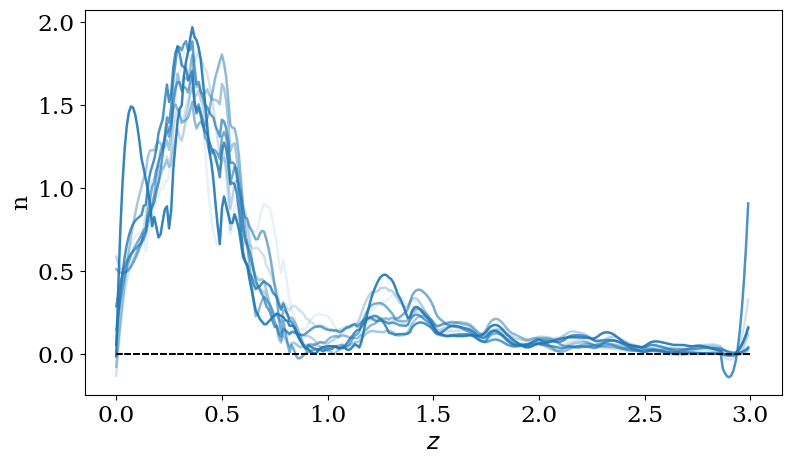

In [14]:
from plot_utils import *

len_pileup = 300
z3 = np.linspace(0, 2.99, len_pileup)
fig = plt.figure(figsize=(9, 5))
for i in range(10):
    plt.plot(z3, leaf_df[0]['pz_pileup_smooth'][i+200], alpha=i/10, color='tab:blue') # OK to have negative values and some big pile-up?
    plt.hlines(0, 0, 3, ls='--', lw=1.2, color='k')
    plt.xlabel(r'$z$')
    plt.ylabel('n')
plt.show()